In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
%matplotlib notebook

In [14]:
Re = np.float64(6378136.)  
f_e = 1 / 298.25784                     # Сжатие земного эллипсоида             ПЗ-90

def spherical_distance(lonlat1, lonlat2):
    lonlat1 = np.deg2rad(lonlat1)
    lonlat2 = np.deg2rad(lonlat2)
    lon1,lat1 = lonlat1[0], lonlat1[1]
    lon2,lat2 = lonlat2[0], lonlat2[1]
    sigma = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1))
    return sigma

class Node:
    def __init__(self, K=None, parent=None):
        assert K is not None or parent, "Either `K` should be provided for root node, or `parent` for internal nodes"
        # Reference to parent node. Used in ANNS search
        self.parent = parent
        # depth start from 0. To compute dimension, relevant to the level, use (self.depth % self.K)
        self.depth = (parent.depth + 1) if parent else 0
        # K means number of vector dimensions
        self.K = parent.K if parent else K
        # value, which splits subspace into to parts using hyperplane: item[self.depth % self.K] == self.pivot
        # pivot is empty for any leaf node.
        self.pivot = None
        # left and right child nodes
        self.left = None
        self.right = None
        # collection of items
        self.items = None
        
    def build_kd_tree(self, items, leaf_capacity=4):
        '''Takes a list of items and arranges it in a kd-tree'''
        assert items is not None, "Please provide at least one point"
        # put all items in the node if they fit into limit
        if len(items) <= leaf_capacity:
            self.items = items
        # or else split items into 2 subnodes using median value
        else:
            self.items = None
            self.left = Node(parent=self)
            self.right = Node(parent=self)
            
            # TODO 1.A.: few lines of code which initialize inernal node.
            self.pivot = None     # here you should write median value with respect to coordinate
            left = None           # those items, which are smaller that pivot value
            right = None          # those items, which are greater that pivot value
            
            p_sorted = sorted(items, key=lambda p: p[0][self.depth % self.K])
            med = len(p_sorted) // 2
            self.pivot = p_sorted[med][0][self.depth % self.K]
            left, right = p_sorted[:med], p_sorted[med:]
            
            self.left.build_kd_tree(left)
            self.right.build_kd_tree(right)

        return self
    
    def kd_find_leaf(self, key):
        ''' returns a node where key should be stored (but can be not present)'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self
        else:
            
            # TODO 1.B. This is a basic operation fo travesing the tree.
            # restore correct condition to continue recursion
            if key[self.depth % self.K] <= self.pivot:
                return self.left.kd_find_leaf(key)
            else:
                return self.right.kd_find_leaf(key)
            
#     def kd_insert_no_split(self, item):
#         '''Naive implementation of insert into leaf node. It is not used in tests of this tutorial.'''
#         node = self.kd_find_leaf(item[0])
#         node.items.append(item)
        
    def kd_insert_with_split(self, item, leaf_capacity=4):
        '''This method recursively splits the nodes into 2 child nodes if they overflow `leaf_capacity`'''
        
        # TODO 1.C. This is very simple insertion procedure.
        # Split the node if it cannot accept one more item.
        # HINT: reuse kd_find_leaf() and build_kd_tree() methods if possible
        
        node = self.kd_find_leaf(item[0])
        node.build_kd_tree((node.items or []) + [item], leaf_capacity)
        
    def get_subtree_items(self):
        '''Returns union of all items belonging to a subtree'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self.items
        else:
            return self.left.get_subtree_items() + self.right.get_subtree_items()
        
    def get_nn(self, key, knn):
        '''Return K approximate nearest neighbours for a given key'''
        node = self.kd_find_leaf(key)
        best = []
        print("aaa")
        # TODO 1.D. ANN search.
        # write here the code which returns `knn` 
        # approximate nearest neighbours with respect to euclidean distance
        # HINT: you can use [scipy.spatial.]distance.euclidean(a, c) - it is already imported
        
        while node is not None and len(best) < knn:
            best = node.get_subtree_items()
            node = node.parent
        best = sorted(best, key=lambda p: spherical_distance(p[0], key))
        
        return best[:knn]
    
    def get_in_range(self, lower_bound_key, upper_bound_key):
        '''Runs range query. Returns all items bounded by the given corners: `lower_bound_key`, `upper_bound_key`'''
        result = []
        if self.pivot is None or self.items is not None: # internal node OR empty root
            # TODO 3.B.: This is a leaf node. Select only those items from self.item
            # which fall into a given range
            for item in self.items:
                _in = [low <= v <= up for low, v, up in zip(lower_bound_key, item[0], upper_bound_key)]
                inside = all(_in)
                if inside:
                    result.append(item)
            return result
        else:
            # TODO 3.B.: This is an internal node.
            # write recursive code to collect corresponding data from subtrees

            skip_right = self.pivot > upper_bound_key[self.depth % self.K]
            skip_left = self.pivot < lower_bound_key[self.depth % self.K]
            result = [] if skip_left else self.left.get_in_range(lower_bound_key, upper_bound_key)
            result += [] if skip_right else self.right.get_in_range(lower_bound_key, upper_bound_key)
            return result

## Загрузка даты по берегам

In [51]:
df = pd.read_csv("coastlines.txt", names=["lat", "lon"])
df.head(1)

,lat,lon
0,0.19244,5.669954


In [53]:
lonlat = [x for x in df.apply(lambda x: np.array([x.lat, x.lon]), axis=1)]
lon = [x[0] for x in lonlat]
lat = [x[1] for x in lonlat]


<IPython.core.display.Javascript object>


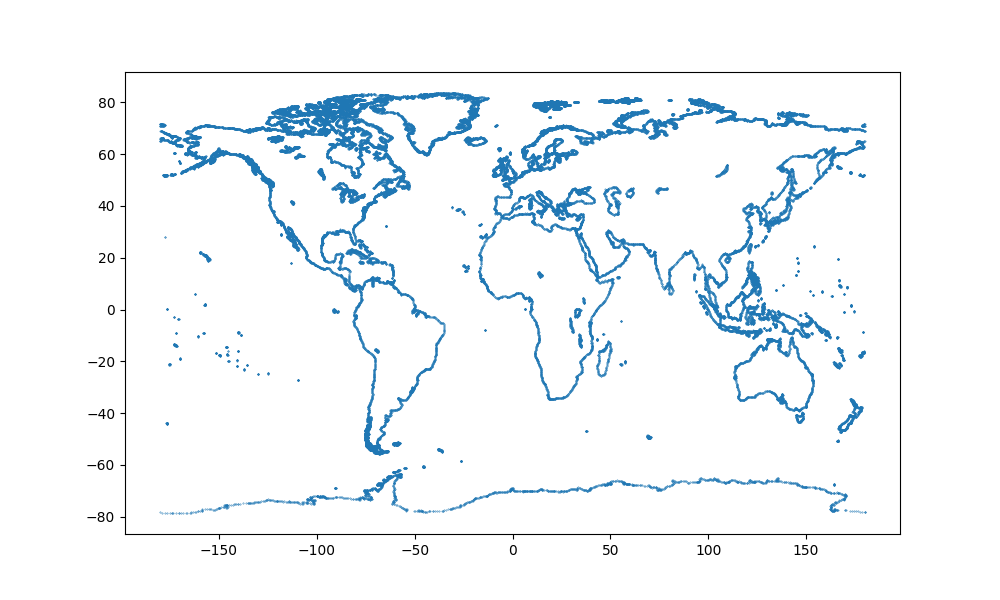

In [54]:
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, s=0.1)
plt.show()

### kdTree без кастомного измерения расстояния

In [64]:
lonlat = [x for x in df.apply(lambda x: np.array([x.lat, x.lon]), axis=1)]
lon = [x[0] for x in lonlat]
lat = [x[1] for x in lonlat]

import scipy
kdTree = scipy.spatial.cKDTree(lonlat)

In [59]:
lonlat

[array([0.19244 , 5.669954]),
 array([-0.114995,  5.515063]),
 array([-0.391921,  5.360171]),
 array([-0.657114,  5.195893]),
 array([-0.887104,  5.151303]),
 array([-1.262597,  5.062123]),
 array([-1.417488,  5.008146]),
 array([-1.560645,  4.874377]),
 array([-1.736658,  4.775809]),
 array([-1.936139,  4.68663 ]),
 array([-2.198985,  4.787544]),
 array([-2.4102  ,  4.874377]),
 array([-2.5956  ,  4.930701]),
 array([-2.771612,  4.951822]),
 array([-2.771612,  4.951822]),
 array([-2.860792,  4.963556]),
 array([-3.003949,  4.97529 ]),
 array([-3.301997,  5.052736]),
 array([-3.611779,  5.106713]),
 array([-3.832382,  5.184159]),
 array([-4.238384,  5.163037]),
 array([-4.679589,  5.106713]),
 array([-5.19824 ,  5.041002]),
 array([-5.341397,  5.008146]),
 array([-5.430576,  5.017534]),
 array([-5.585468,  4.984678]),
 array([-5.848313,  4.918966]),
 array([-6.08065 ,  4.796931]),
 array([-6.223807,  4.754688]),
 array([-6.444409,  4.677242]),
 array([-6.64389 ,  4.599797]),
 array([-6

In [65]:
point = np.array([-46.42, 12.48])
dists, iPs = kdTree.query(point, k=5)
dists, iPs

(array([9.52763711, 9.52831582, 9.55806302, 9.5687461 , 9.57520593]),
 array([177, 176, 175, 174, 172], dtype=int64))

### Здесь я пробую класс HaversineDistance, сравниваю расчет с формулой из Морозова

<IPython.core.display.Javascript object>


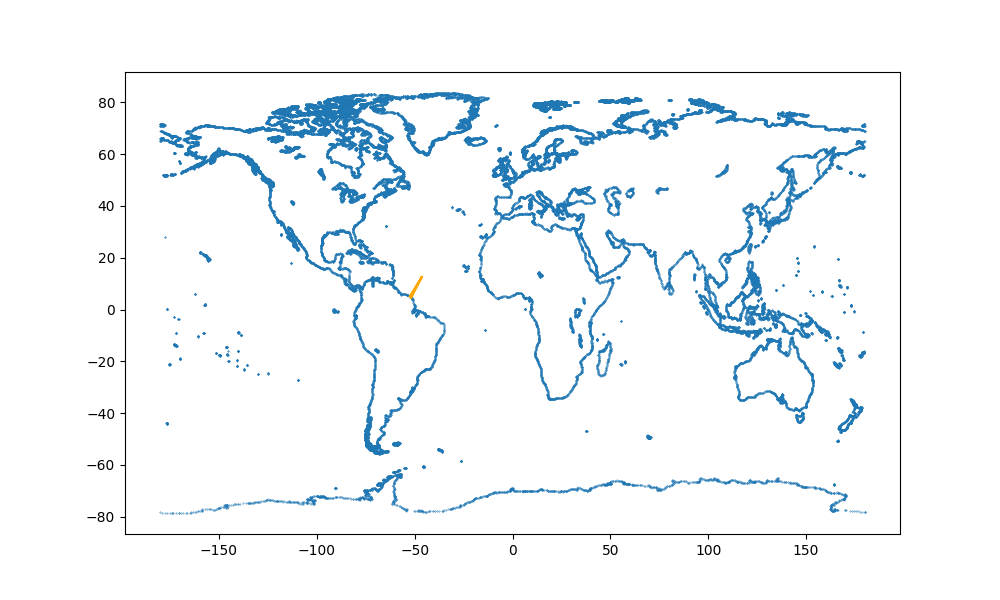

1054.1347890999332
[[1054.1347891]]
1054.669534482051
[[1054.66953448]]
1058.1428344081835
[[1058.14283441]]
1059.59177087565
[[1059.59177088]]
1060.805749339659
[[1060.80574934]]


In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, s=0.1)

dist_obj = DistanceMetric.get_metric('haversine')

for idx in iPs:
    kNN = lonlat[idx]
    dist = spherical_distance(point, kNN)
    print(dist * 6371)
    print(6371 * dist_obj.pairwise(np.deg2rad(kNN)[::-1][np.newaxis], np.deg2rad(point)[::-1][np.newaxis]))

    line = np.vstack((point, kNN))
    plt.plot(line[:,0], line[:,1], color="orange")
plt.show()

[array([5.669954, 0.19244 ]),
 array([ 5.515063, -0.114995]),
 array([ 5.360171, -0.391921]),
 array([ 5.195893, -0.657114]),
 array([ 5.151303, -0.887104]),
 array([ 5.062123, -1.262597]),
 array([ 5.008146, -1.417488]),
 array([ 4.874377, -1.560645]),
 array([ 4.775809, -1.736658]),
 array([ 4.68663 , -1.936139]),
 array([ 4.787544, -2.198985]),
 array([ 4.874377, -2.4102  ]),
 array([ 4.930701, -2.5956  ]),
 array([ 4.951822, -2.771612]),
 array([ 4.951822, -2.771612]),
 array([ 4.963556, -2.860792]),
 array([ 4.97529 , -3.003949]),
 array([ 5.052736, -3.301997]),
 array([ 5.106713, -3.611779]),
 array([ 5.184159, -3.832382]),
 array([ 5.163037, -4.238384]),
 array([ 5.106713, -4.679589]),
 array([ 5.041002, -5.19824 ]),
 array([ 5.008146, -5.341397]),
 array([ 5.017534, -5.430576]),
 array([ 4.984678, -5.585468]),
 array([ 4.918966, -5.848313]),
 array([ 4.796931, -6.08065 ]),
 array([ 4.754688, -6.223807]),
 array([ 4.677242, -6.444409]),
 array([ 4.599797, -6.64389 ]),
 array([ 4

### BallTree с кастомным измерением расстояния

In [67]:
import numpy as np
from sklearn.neighbors import *
dist_obj = DistanceMetric.get_metric('haversine')

latlon = [x for x in df.apply(lambda x: np.array([x.lon, x.lat]), axis=1)]
latlon = np.deg2rad(latlon)
tree = BallTree(latlon, leaf_size=2, metric=dist_obj) 
dists, iPs = tree.query(np.deg2rad(point[::-1])[np.newaxis], k = 5)

<IPython.core.display.Javascript object>


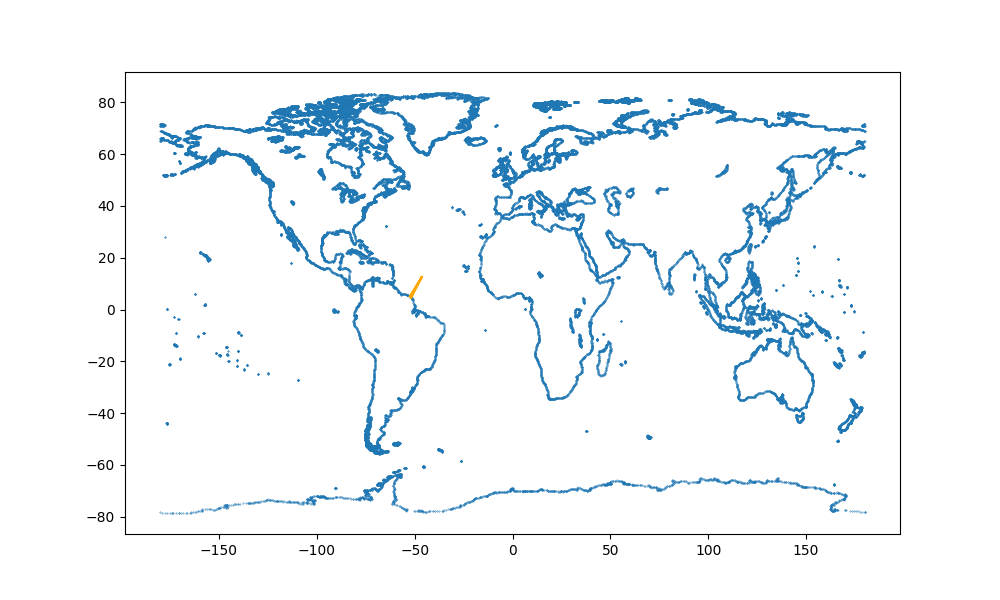

[-52.454112   5.106713]
1054.1347890999336
[-52.233509   4.930701]
1054.6695344820532
[-52.165451   4.841521]
1058.1428344081862
[-52.034028   4.73122 ]
1059.5917708756522
[-51.759449   4.531739]
1060.805749339663


In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(lon, lat, s=0.1)

for dist, idx in zip(dists[0], iPs[0]):
    kNN = np.rad2deg(latlon[idx])[::-1]
    print(kNN)
    print(dist * 6371)

    line = np.vstack((point, kNN))
    plt.plot(line[:,0], line[:,1], color="orange")
plt.show()

### Вывод

Собственный класс kdTree плохо ищет соседей. kdTree из модуля scipy работает лучше. В итоге решено использовать структуру BallTree с кастомной метрикой  DistanceMetric.get_metric('haversine')